In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

The data is saved in numpy arrays. 
Each array has shape $\texttt{n\_images} \times \texttt{height} \times \texttt{width} \times \texttt{n\_channels}$.
Number of channels is 1 for CT scans (grayscale images) and 4 for masks, because there are 4 masks:
* "ground glass"
* "consolidation"
* "lungs other"
* "background"

In [2]:
prefix = Path("covid-segmentation-data/")

images_radiopedia = np.load(prefix / "images_radiopedia.npy").astype(np.float32)
masks_radiopedia = np.load(prefix / "masks_radiopedia.npy").astype(np.int8)
images_medseg = np.load(prefix / "images_medseg.npy").astype(np.float32)
masks_medseg = np.load(prefix / "masks_medseg.npy").astype(np.int8)

test_images_medseg = np.load(prefix / "test_images_medseg.npy").astype(np.float32)

In [3]:
print(
    f"There are {images_medseg.shape[0]} MedSeg images and {images_radiopedia.shape[0]} Radiopaedia images."
)
print(f"There are also {test_images_medseg.shape[0]} test images with unknown masks.")

There are 100 MedSeg images and 829 Radiopaedia images.
There are also 10 test images with unknown masks.


All images are $512 \times 512$ pixels:

In [4]:
for array in (
    images_medseg,
    masks_medseg,
    images_radiopedia,
    masks_radiopedia,
    test_images_medseg,
):
    assert array.shape[1] == array.shape[2] == 512

## Visualize data

This function for visualizing data comes from a notebook of the competition's author:
[keras baseline.ipynb](https://www.kaggle.com/code/maedemaftouni/pytorch-baseline-for-semantic-segmentation)

The visualization shows different data points in each column. The rows are in the following order: CT scan, "ground glass", "consolidation", "lungs other", "background".

Looking at few samples, it's clear that the scans looks quite differently. Firstly, it looks like images from MedSeg were taken in different conditions: they vary in shape and scale.
In contrast, images from Radiopaedia looks very similar to each other. 

Secondly, some of the images from Radiopaedia have empty masks corresponding to "ground glass" and "consolidation". CT scans shows different, horizontal slices of a body.
It looks like some of the Radiopaedia scans here shows other areas than lungs, e.g. stomach. It explain why in the data descritpion it is said that only 373 out of 829 scans were evaluated as positive and segmented by a radiologist).

In [5]:
def visualize_batch(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(
        num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2)
    )

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i, :, :, 0], cmap="Greys")
        ax_image.set_xticks([])
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i, :, :, j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    mask_to_show[..., 0] = pred_batch[i, :, :, j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i, :, :, j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

Sample 8 images from MedSeg. You can see that they were taken in different conditions and they scale is different:

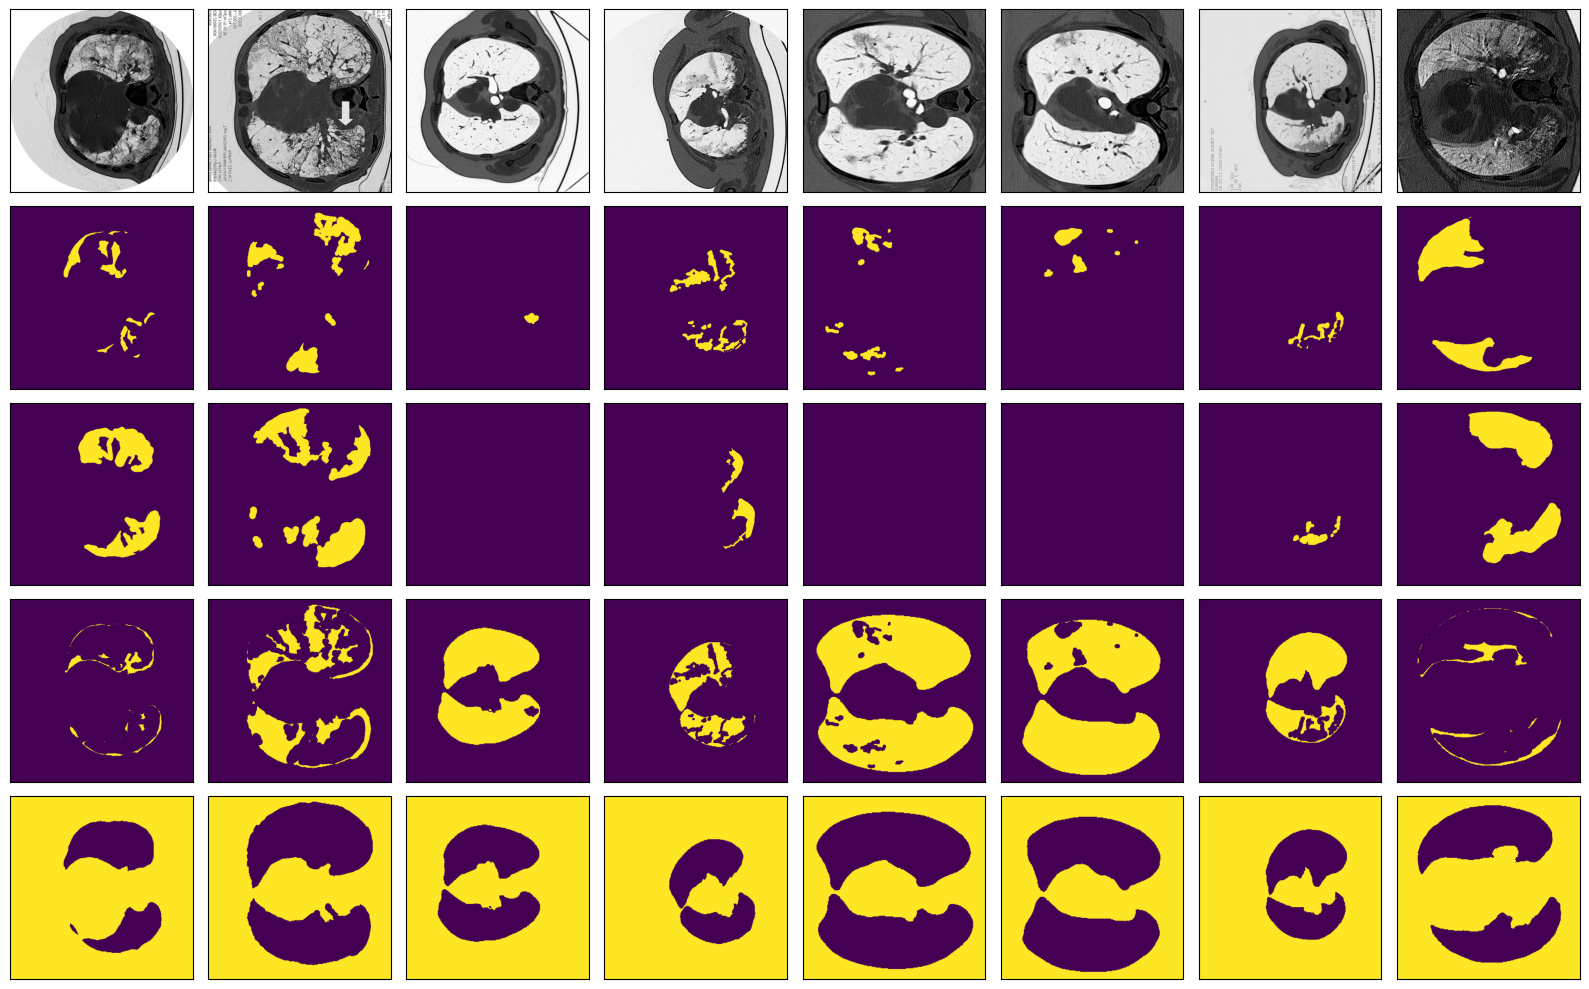

In [6]:
visualize_batch(images_medseg, masks_medseg)

Sample images from Radiopaedia. In this example, they contain either no lungs or show just a small portion of lungs. 
The values were calibrated in such a way to show lungs clearly. It means that other areas (e.g. stomach) are quite dark.

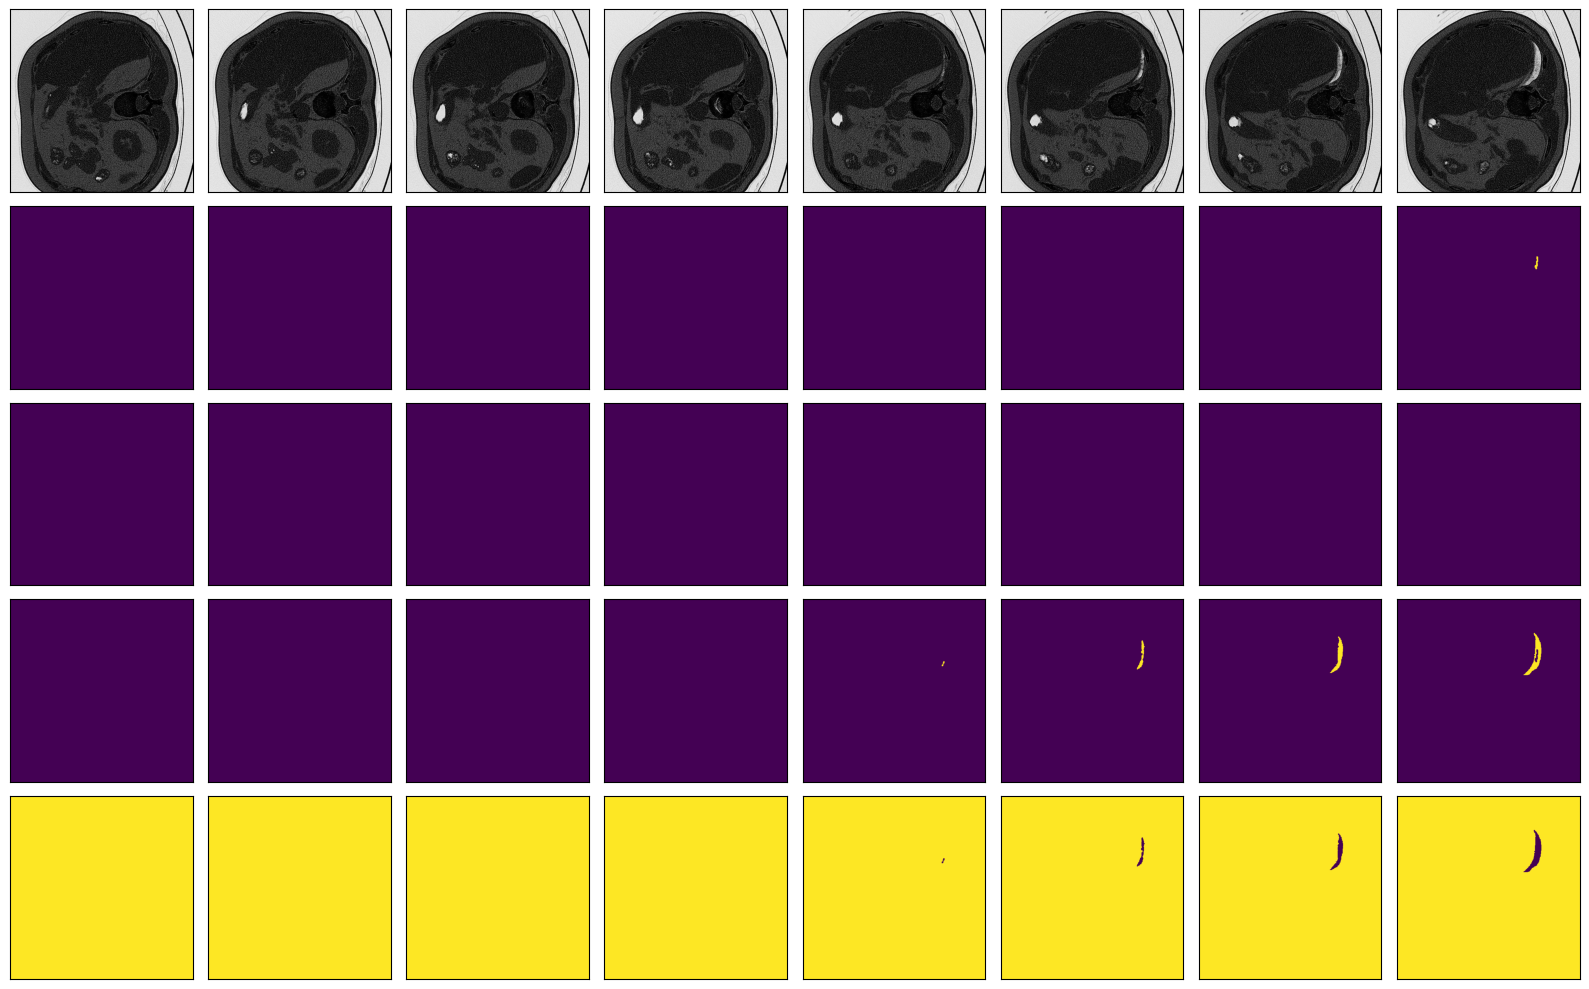

In [7]:
visualize_batch(images_radiopedia, masks_radiopedia)

Another set of images from Radiopaedia. These are proper lungs scans. They also have annotated "ground glass" and "consolidations":

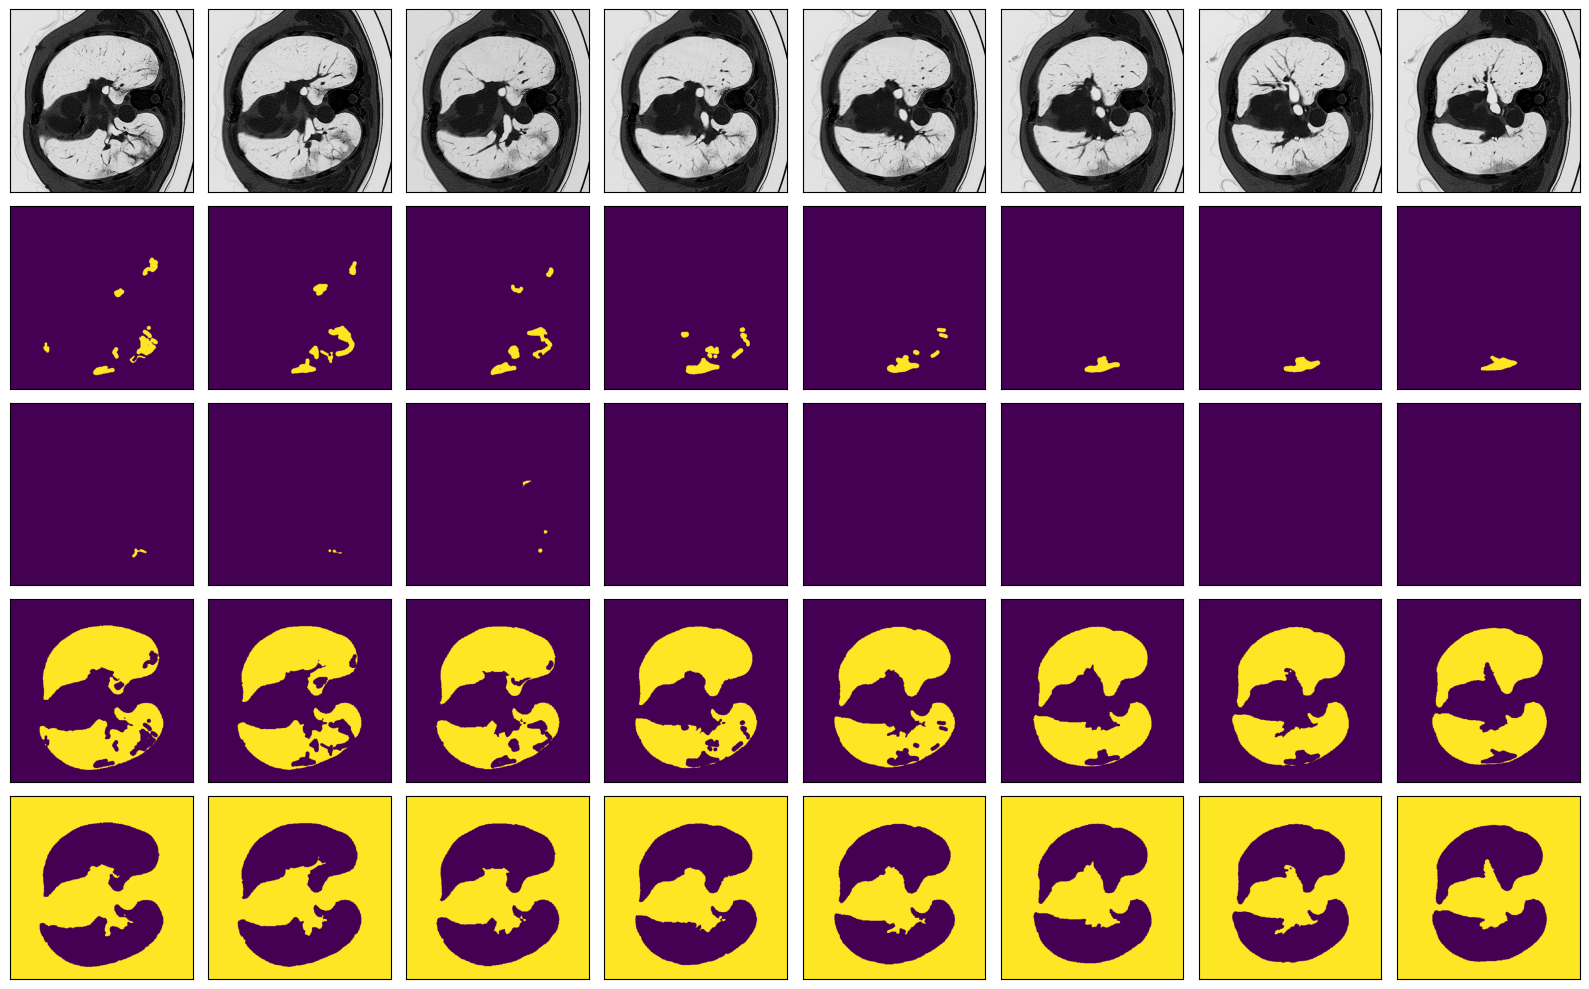

In [8]:
visualize_batch(images_radiopedia[30:], masks_radiopedia[30:])

### Test images

Finally, I will show all 10 test images which are used to evaulate solutions on the Kaggle leaderboard:

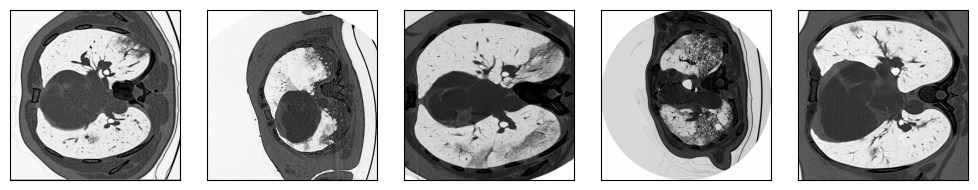

In [9]:
visualize_batch(test_images_medseg, num_samples=5)

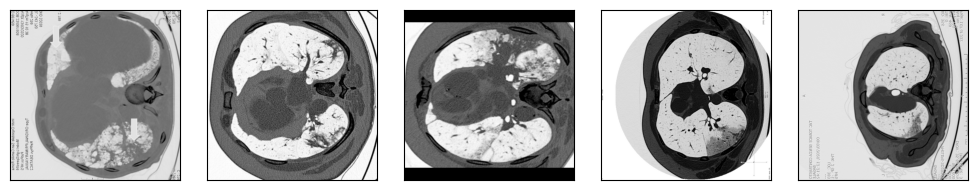

In [10]:
visualize_batch(test_images_medseg[5:], num_samples=5)

## Categories count

In the images above you can notice that not all scans exibit both "ground glass" and "consolidations" at the same time. Moreover, some of scans don't show neither of these two categories.
Let's count how many there are such cases.

In [11]:
from collections import defaultdict


def count_classes(masks):
    class_names = ["ground_glass", "consolidations", "other", "background"]
    class_count = defaultdict(int)

    for class_name, channel in zip(class_names, range(4)):
        for mask in masks:
            if mask[:, :, channel].sum() != 0:
                class_count[class_name] += 1
    return class_count

All of MedSeg images show lungs (because "other" equals 100, which is a number of all MedSeg images).
96 scans show some "ground_glass" and 78 show some "consolidations".

In [12]:
count_classes(masks_medseg)

defaultdict(int,
            {'ground_glass': 96,
             'consolidations': 78,
             'other': 100,
             'background': 100})

How many MedSeg scans show either "ground_glass" or "consolidations"?

In [13]:
ground_glass_or_consolidations = np.any(
    masks_medseg[..., 0] | masks_medseg[..., 1], axis=(1, 2)
)
print(ground_glass_or_consolidations.sum())

99


There is one scan (with index 48) which doesn not exibit neither of the two target classes:

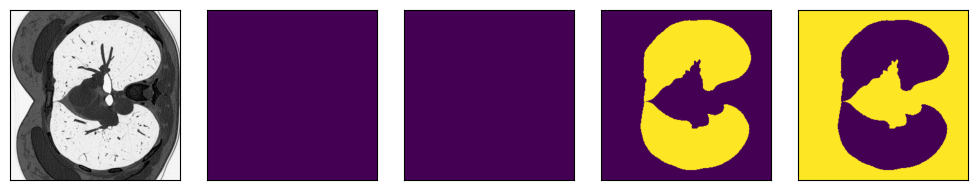

In [14]:
img_idx = ground_glass_or_consolidations.argmin()
fix, ax = plt.subplots(1, 5, figsize=(10, 2))

ax_image = ax[0]
ax_image.imshow(images_medseg[img_idx, :, :, 0], cmap="Greys")
ax_image.set_xticks([])
ax_image.set_yticks([])

for j in range(4):
    mask_to_show = masks_medseg[img_idx, :, :, j]
    ax[j + 1].imshow(mask_to_show, vmin=0, vmax=1)
    ax[j + 1].set_xticks([])
    ax[j + 1].set_yticks([])

plt.tight_layout()
plt.show()

What can we say about the other dataset, Radiopaedia? Out of 829 scans 713 show some lung area.
However, there is only 297 scans showing "ground_glass" and only 233 scans showing "consolidations".
And only 372 scans show at least one of the two target classes.

In [15]:
count_classes(masks_radiopedia)

defaultdict(int,
            {'ground_glass': 297,
             'consolidations': 233,
             'other': 713,
             'background': 829})

In [16]:
ground_glass_or_consolidations = np.any(
    masks_radiopedia[..., 0] | masks_radiopedia[..., 1], axis=(1, 2)
)
print(ground_glass_or_consolidations.sum())

372


Let's finally visualize class count for the joint MedSeg and Radiopaedia data

In [17]:
all_masks = np.concatenate((masks_medseg, masks_radiopedia))
class_counter = count_classes(all_masks)

class_counter["both_ground_glass_and_consolidations"] = (
    np.any(all_masks[..., 0], axis=(1, 2)) & np.any(all_masks[..., 1], axis=(1, 2))
).sum()

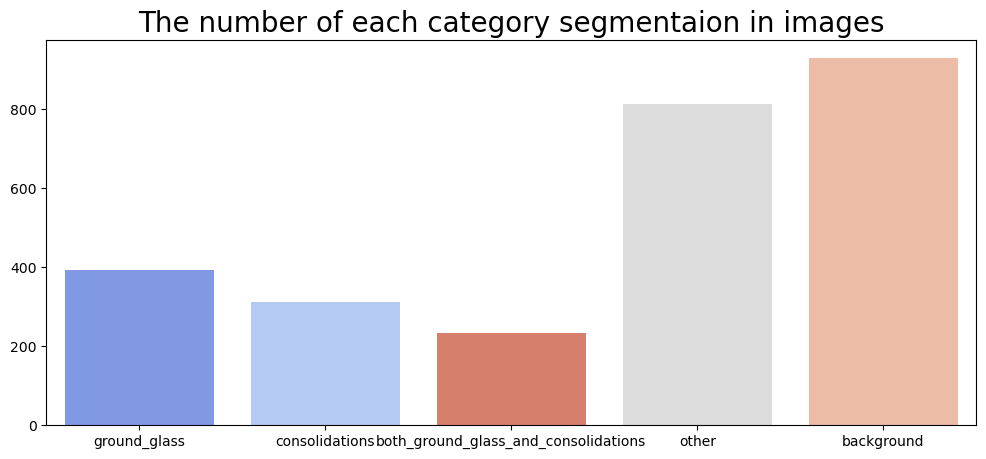

In [18]:
x = class_counter.keys()
y = class_counter.values()

plt.figure(figsize=(12, 5))
plt.title("The number of each category segmentaion in images", fontsize=20)
_ = sns.barplot(
    x=x,
    y=y,
    hue=x,
    palette="coolwarm",
    order=[
        "ground_glass",
        "consolidations",
        "both_ground_glass_and_consolidations",
        "other",
        "background",
    ],
)

## Range of grayscale values

Currently the values of the grayscale scans vary from -1607 to 598:

In [19]:
images_medseg.min(), images_medseg.max()

(-1606.5217, 597.8047)

The scans values were normalized from Hounsfield Units to emphasize lungs. The normalization process is described in 
[Covid-19 radiology — data collection and preparation for Artificial Intelligence](https://medium.com/@hbjenssen/covid-19-radiology-data-collection-and-preparation-for-artificial-intelligence-4ecece97bb5b).

>> What are Hounsfield Units? They correspond to radiodensities of different materials, like air, water or human tissues. You can read more about it in Radiopaedia: [Hounsfield Unit](https://radiopaedia.org/articles/hounsfield-unit).

You see the distribution of grayscale values of MedSeg and Radiopaedia scans:

In [20]:
def plot_hists(images1, images2=None):
    plt.hist(
        images1.ravel(),
        bins=100,
        density=True,
        color="b",
        alpha=1 if images2 is None else 0.5,
    )
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color="orange")
    plt.show();

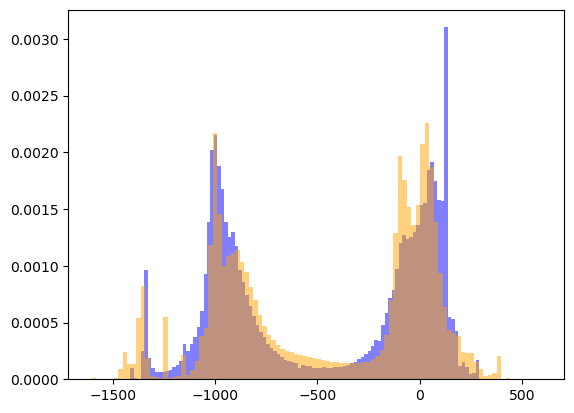

In [21]:
plot_hists(images_radiopedia, images_medseg)

## Learnings from exploratory data analysis

1. Scans from  MedSeg and Radiopaedia look different
2. Not all scans from Radiopaedia exhibit any of the two target classes (("ground_glass" and "consolidations"). Some of them don't even show lungs area! It could be beneficial to drop such samples and train a model only on data showing actual cases to be segmented.
3. The data should be normalized. Pretrained models are used to data which is normally distribued.

*The notebook was run on `ml.t3.large`*